In [2]:
import os
from tqdm import tqdm

import numpy as np
from matplotlib import pyplot as plt

import torch
from torchvision import models, transforms

from tensorflow import keras
from keras.layers import Input, Dense  
from keras.models import Model

import cv2

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [4]:
f = []
for (dirpath, dirnames, filenames) in os.walk(os.path.join("images", "left")):
    f.extend(filenames)
    break
len(f)

2776

In [5]:
fast = cv2.FastFeatureDetector_create()

In [6]:
from IPython.display import clear_output

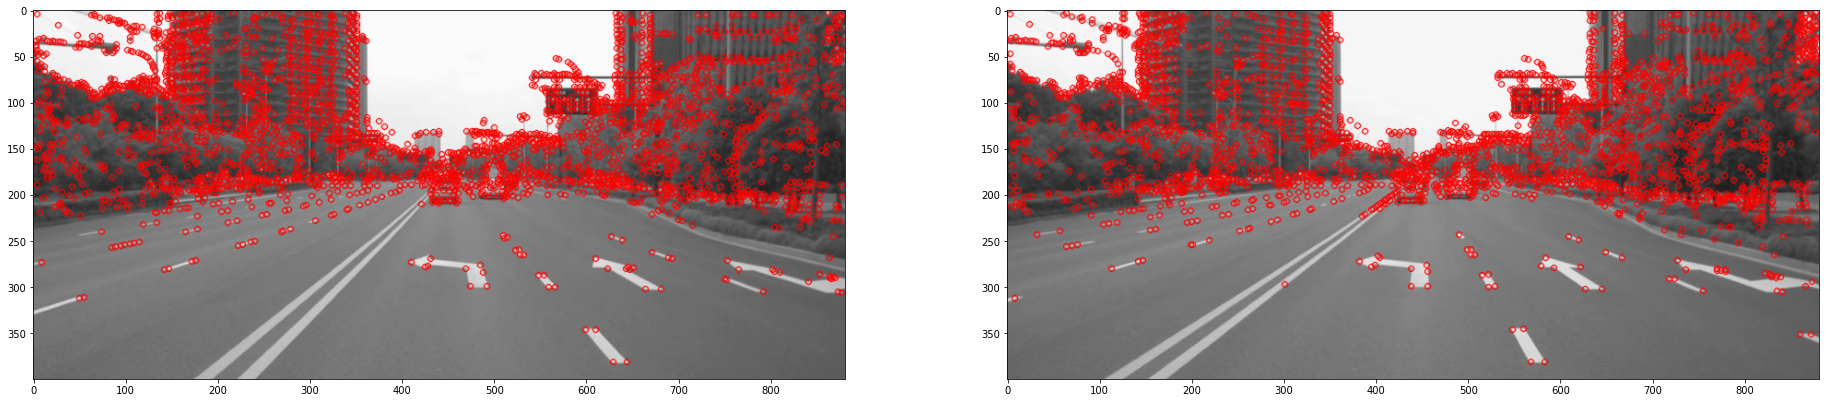

In [51]:
for fname in f[0:1]:
    img1 = cv2.imread(os.path.join("images", "left" , fname))
    img2 = cv2.imread(os.path.join("images", "right", fname))

    keypoints1 = fast.detect(img1, None)
    keypoints2 = fast.detect(img2, None)

    
    imgL = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    imgR = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    imgL = cv2.drawKeypoints(imgL, keypoints1, None, color=(255,0,0))
    imgR = cv2.drawKeypoints(imgR, keypoints2, None, color=(255,0,0))

    figure, ax = plt.subplots(1, 2, figsize=(32, 16))
    ax[0].imshow(imgL, cmap='gray')
    ax[1].imshow(imgR, cmap='gray')

    plt.show()
    clear_output(wait=True)

In [18]:
# def get_image_patches(img, keypoints, S=64): # S = patch size
#     _patches = []

#     try:
#         imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
#         for keypoint in keypoints:
#             point = keypoint.pt

#             x1 = int(point[0])-S//2
#             y1 = int(point[1])-S//2
            
#             if (x1 > 0 and y1 > 0
#                 and x1+S < img.shape[0] 
#                 and y1+S < img.shape[1]):

#                 _patches.append(imgray[x1:x1+S, y1:y1+S])

#     except Exception as e:
#         print(e)
    
#     return _patches

In [9]:
class FeatureExtractor(torch.nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
	
        # Extract VGG-16 Feature Layers
        self.features = list(model.features)
        self.features = torch.nn.Sequential(*self.features)
        
        # Extract VGG-16 Average Pooling Layer
        self.pooling = model.avgpool
        
        # Convert the image into one-dimensional vector
        self.flatten = torch.nn.Flatten()
        
        # Extract the first part of fully-connected layer from VGG16
        self.fc = model.classifier[0]
  
    def forward(self, x):
        # It will take the input 'x' until it returns the feature vector called 'out'
        out = self.features(x)
        out = self.pooling(out)
        out = self.flatten(out)
        out = self.fc(out) 
        return out 

In [10]:
# Initialize the model
model = models.vgg16(pretrained=True)
fvgg16 = FeatureExtractor(model)

fvgg16 = fvgg16.to(device)

In [55]:
def get_features(img_patches):
    # Transform the image, so it becomes readable with the model
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.CenterCrop(512),
        transforms.Resize(448),
        transforms.ToTensor()                              
    ])

    features = []

    for img in tqdm(img_patches):
        img = transform(img)
        
        # Reshape the image. PyTorch model reads 4-dimensional tensor
        # [batch_size, channels, width, height]
        img = img.reshape(1, 3, 448, 448)
        img = img.to(device)

        # We only extract features, so we don't need gradient
        with torch.no_grad():
            # Extract the feature from the image
            feature = fvgg16(img)

            features.append(feature.cpu().detach().numpy().reshape(-1))

    features = np.array(features)
    return features

In [12]:
def autoencoder(des, enconding_dim=256):
    input_img = Input(shape=(des.shape[1],))  

    encoded = Dense(1024, activation='relu')(input_img)  
    encoded = Dense(512, activation='relu')(encoded)  
    decoded_input = Dense(enconding_dim, activation='relu')(encoded)  
  
    decoded = Dense(512, activation='relu')(decoded_input)  
    decoded = Dense(1024, activation='relu')(decoded)  
    decoded = Dense(des.shape[1], activation='relu')(encoded)  
  
    autoencoder = Model(inputs=input_img, outputs=decoded)  
    encoder = Model(inputs=input_img, outputs=decoded_input)  
  
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')  
 
    autoencoder.fit(des, des, epochs=20, batch_size=16, shuffle=False)  

    encoded_imgs = encoder.predict(des)  

    print(encoded_imgs.shape)

    return encoded_imgs

In [39]:
from extract_patches.core import extract_patches

PATCH_SIZE = 64
mrSize = 1.0

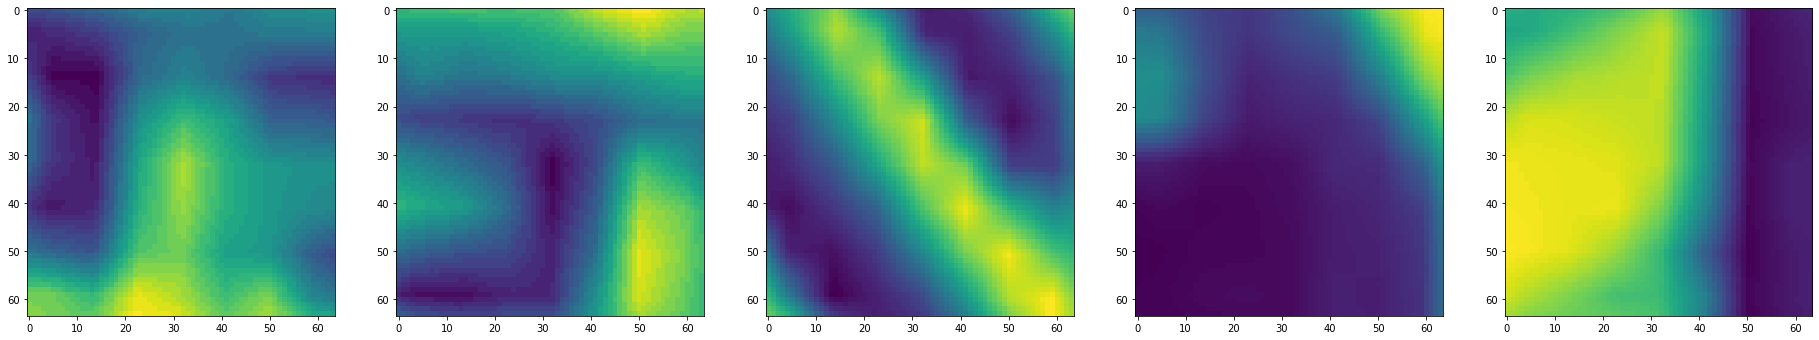

In [40]:
# patches = extract_patches(keypoints1, img1, PATCH_SIZE, mrSize, 'cv2')

# show_idx = 300
# fig = plt.figure(figsize=(32, 16))
# for i in range(1,6):
#     fig.add_subplot(1, 5, i) 
#     plt.imshow(patches[show_idx+i])

In [52]:
patches1 = extract_patches(keypoints1, img1, PATCH_SIZE, mrSize, 'cv2')
patches2 = extract_patches(keypoints2, img2, PATCH_SIZE, mrSize, 'cv2')

In [ ]:
descriptors1 = autoencoder(get_features(patches1[:20]))
descriptors2 = autoencoder(get_features(patches2[:20]))

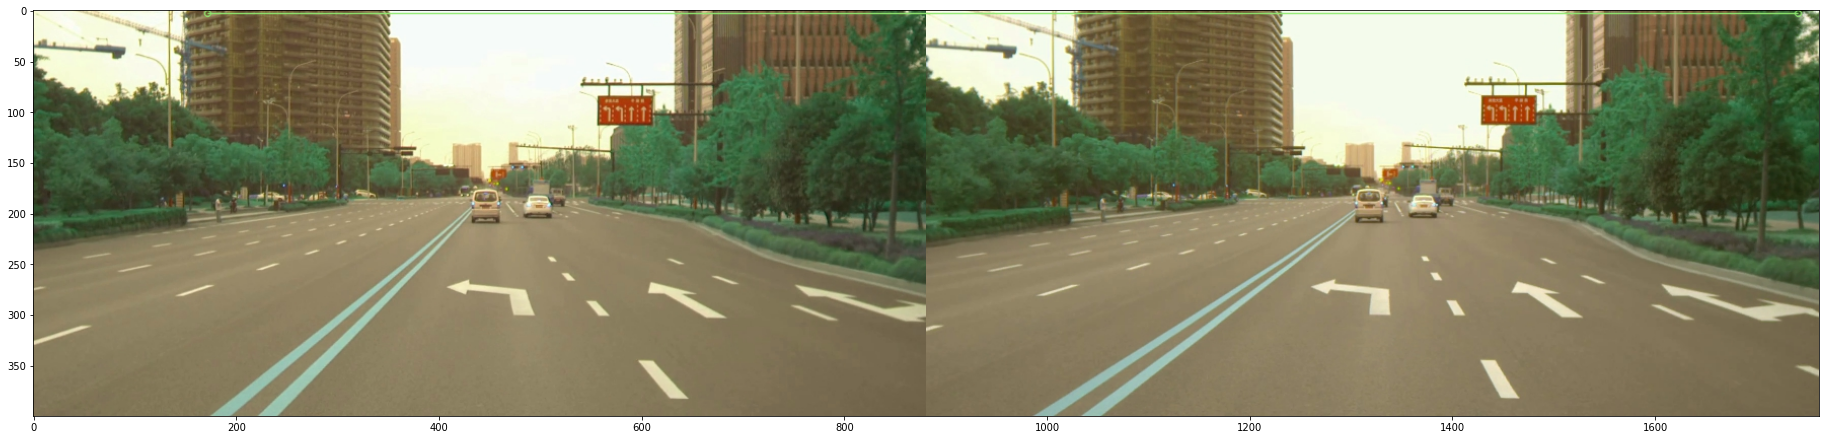

In [100]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

matches = bf.match(descriptors1, descriptors2)
matches = sorted(matches, key = lambda x: x.distance)

img3 = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches, img2, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(32,16))
plt.imshow(img3, cmap='gray')

In [101]:
matches

[<DMatch 00000183989B4710>]

In [90]:
def brute_force_match(keypoints1, descriptors1, keypoints2, descriptors2):
    from scipy.spatial import distance
    matches = []
    for k1, des1 in zip(cv2.KeyPoint_convert(keypoints1).astype(np.int32), descriptors1):
        l = []
        for k2, des2 in zip(cv2.KeyPoint_convert(keypoints2).astype(np.int32), descriptors2):
            l.append({
                "point1": k1, 
                "point2": k2,
                "dist": distance.hamming(des1, des2)
            })

        l.sort(key=(lambda corner: corner["dist"]))
        matches.append(l[0])

    return matches

In [91]:
matches = brute_force_match(keypoints1, descriptors1, keypoints2, descriptors2)

In [96]:
def plot_matches(matches, fig, ax1, ax2):
    from matplotlib.patches import ConnectionPatch
    for match in matches:
        point1, point2 = match["point1"], match["point2"]
        con = ConnectionPatch(xyA=[point1[1], point1[0]], xyB=[point2[1], point2[0]], coordsA="data", coordsB="data", axesA=ax1, axesB=ax2, color="red")
        fig.add_artist(con)
    

In [93]:
def plot_img_with_corners(img, keypoints, ax, title):
    ax.imshow(img, cmap="gray")
    for point in cv2.KeyPoint_convert(keypoints).astype(np.int32):
        ax.scatter(point[0], point[1], facecolors='none', edgecolors='r', s=16)
    ax.title.set_text(title)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

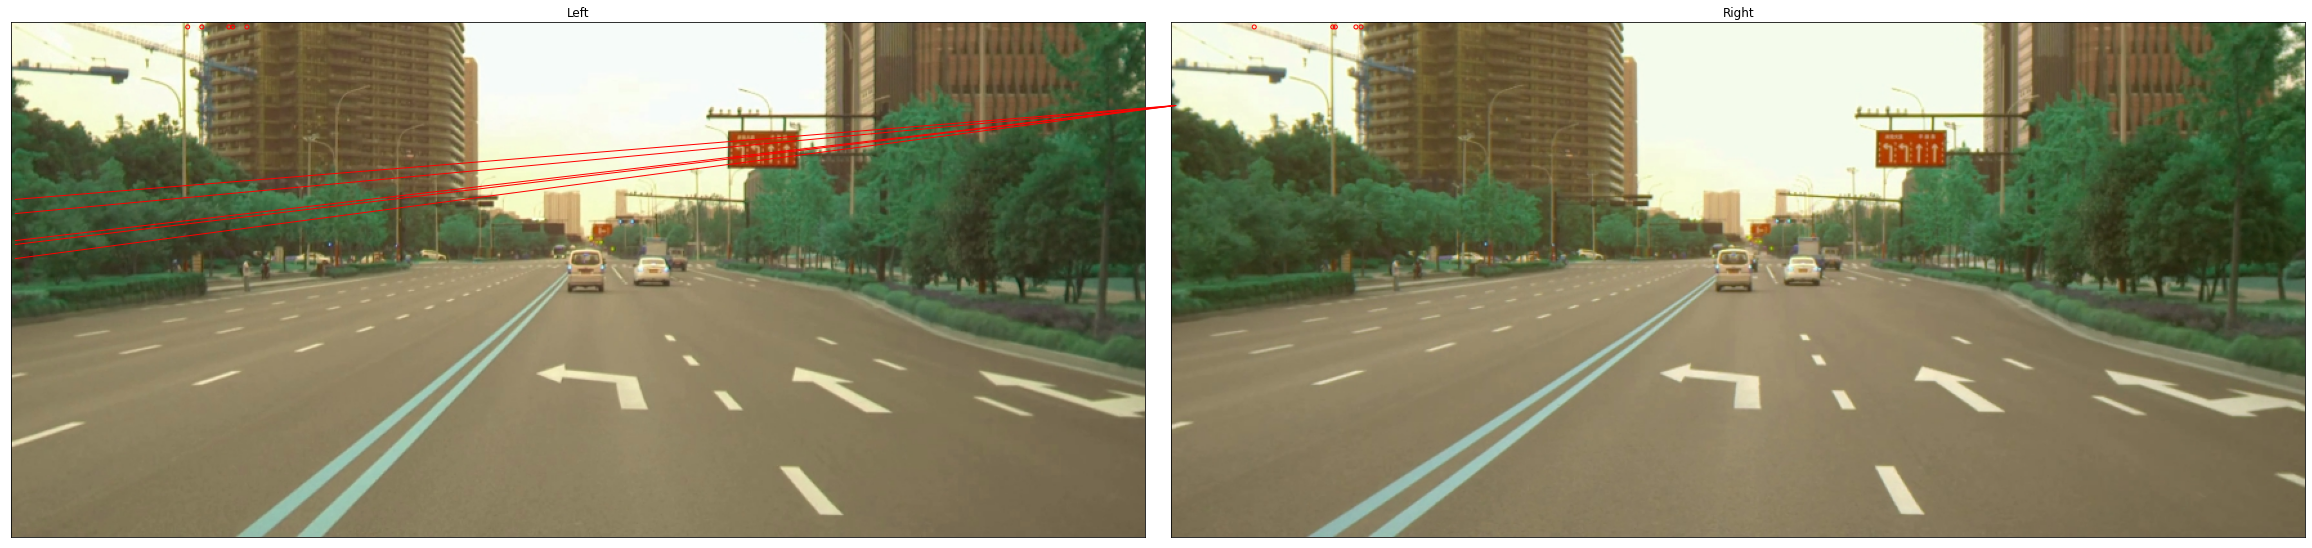

In [97]:
fig, ax = plt.subplots(1, 2, figsize=(32, 16), constrained_layout=True)

plot_img_with_corners(img1, keypoints1[:5], ax[0], "Left")
plot_img_with_corners(img2, keypoints2[:5], ax[1], "Right")

plot_matches(matches, fig, ax[0], ax[1])